- https://scikit-learn.org/stable/modules/preprocessing.html#


# Pre-requisites

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing

In [34]:
%matplotlib inline

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Ingestion

In [3]:
rawData = fetch_california_housing()
print(type(rawData))
print(rawData.DESCR)

<class 'sklearn.utils._bunch.Bunch'>
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1

In [4]:
dfHousing = pd.DataFrame(data=rawData.data, columns=rawData.feature_names)
dfHousing.sample(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
16439,3.8750,27.0,6.285714,0.992481,303.0,2.278195,38.14,-121.29
4504,1.7054,40.0,3.963370,1.164835,1085.0,3.974359,34.05,-118.20
19428,3.2447,12.0,4.936859,1.028602,4656.0,2.512682,37.70,-121.01
1818,5.1067,40.0,6.353430,1.016632,1103.0,2.293139,37.93,-122.32
18463,4.6500,15.0,3.425806,0.993548,469.0,3.025806,37.20,-121.70


In [5]:
print(rawData.target_names)
dfHousing['MedHouseVal'] = pd.Series(rawData.target)
dfHousing.info()

['MedHouseVal']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


# Data preparation

In [6]:
# no missing values found
dfHousing.dropna().shape

(20640, 9)

## Outlier analysis

<Axes: >

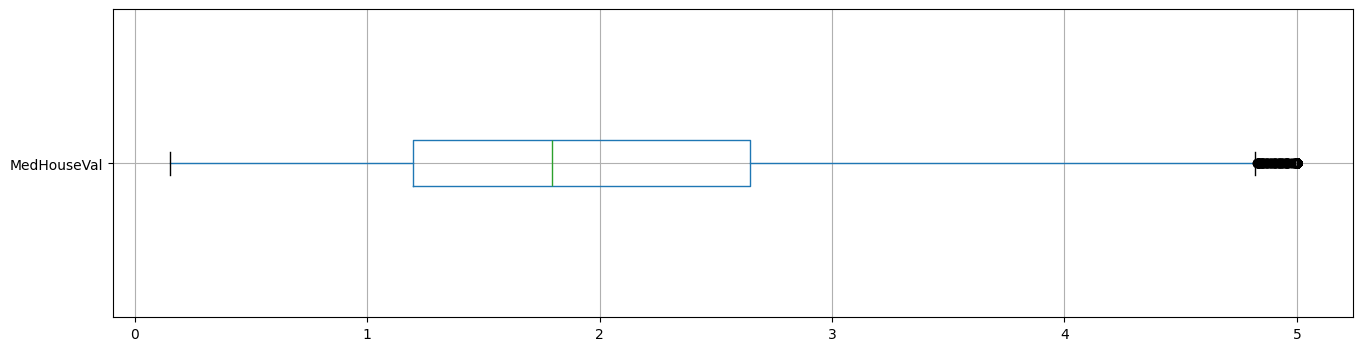

In [7]:
# box plot shows outliers at the top
dfHousing.boxplot(column='MedHouseVal', vert=False, figsize=(16,4))

In [8]:
dfHousing['MedHouseVal'].median()

np.float64(1.797)

In [9]:
dfHousing['MedHouseVal'].mean()

np.float64(2.068558169089147)

In [10]:
# histogram shows higher frequency of observations at the top-end
fig, ax = plt.subplots(1, 1)
dfHousing['MedHouseVal'].plot.hist(ax=ax, bins=20, edgecolor='black')

<Axes: ylabel='Frequency'>

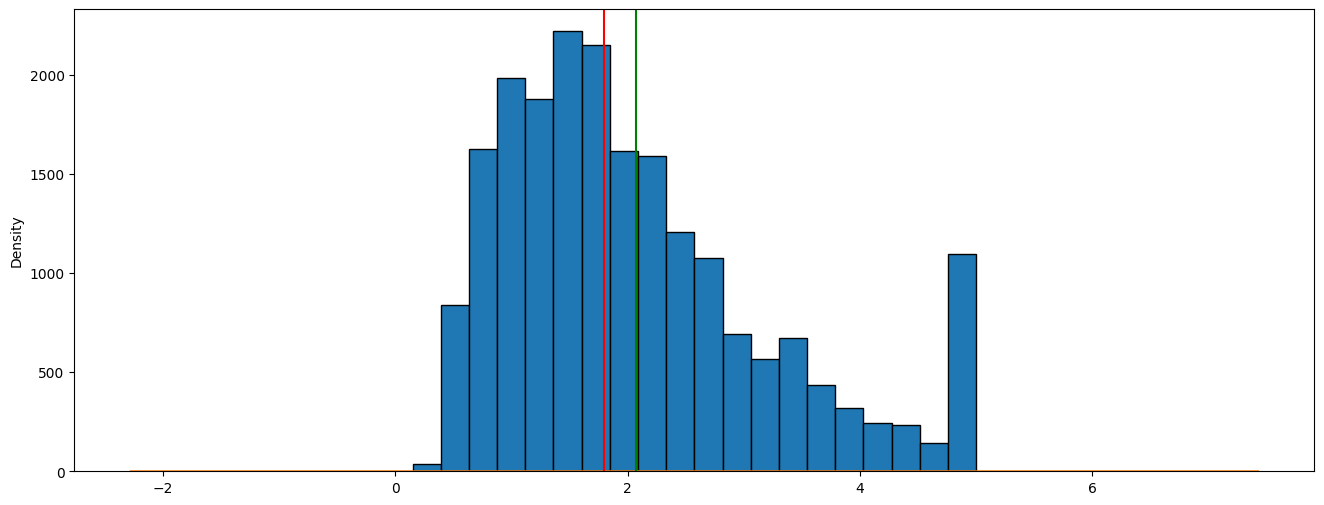

In [11]:
# probability density function shows a right-skewed distribution:
    # peak of the distribution is on the left side.
    # mean is greater than the median.
dfHousing['MedHouseVal'].plot.density(figsize=(16, 6))
plt.axvline(x=dfHousing['MedHouseVal'].median(),color='r', label='median')
plt.axvline(x=dfHousing['MedHouseVal'].mean(),color='g', label='mean')
plt.show()

In [12]:
print(dfHousing.MedHouseVal.max())
# counting the records which have the highest value
dfHousing.loc[dfHousing.MedHouseVal == dfHousing.MedHouseVal.max()].shape

5.00001


(965, 9)

## Outlier treatment(removal)

In [13]:
print(dfHousing.shape[0] - 965)
dfHousing = dfHousing.loc[dfHousing.MedHouseVal != 5.00001]
dfHousing.shape

19675


(19675, 9)

## One-hot encoding categorical values

In [14]:
# no string features to encode
dfHousing.dtypes

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

In [15]:
dfX = dfHousing.drop('MedHouseVal', axis=1)
print(dfX.columns)
dsY = dfHousing['MedHouseVal']
print(dsY.name)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')
MedHouseVal


## Train, Test split

In [16]:
# 80-20 split
# shuffle the dataset to limit inadverdent patterns in data
xTrain, xTest, yTrain, yTest = train_test_split(dfX, dsY, test_size=0.2, shuffle=True)
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

(15740, 8) (3935, 8) (15740,) (3935,)


## Standardization

In [17]:
# Standardize features by removing the mean and scaling to unit variance 
# i.e., mean becomes 0, std dev becomes 1
# It is possible to disable either centering or scaling by either passing with_mean=False or with_std=False to the constructor
scaler = StandardScaler(with_mean=True, with_std=True).fit(xTrain)
type(scaler)


sklearn.preprocessing._data.StandardScaler

In [18]:
xTrainScaled = scaler.transform(xTrain)
xTestScaled = scaler.transform(xTest)

# Training

In [19]:
# Non-negative least squares
# Normalization scales all numeric features between (0, 1)
modelLinear = LinearRegression(positive=False).fit(xTrain, yTrain)

In [20]:
# evaluating how the model performs on the training dataset
# R-square score measures how well the model captures the variation in the training data
modelLinear.score(xTrain, yTrain)

0.5637913042045544

In [21]:
# these are the coefficients assigned by the model to each independant variable
# it explains how much each variable contributes to the prediction
dsCoefficients = pd.Series(data=modelLinear.coef_, index=xTrain.columns)
dsCoefficients.sort_values()

Longitude    -0.390631
Latitude     -0.373555
AveRooms     -0.112655
AveOccup     -0.003168
Population    0.000006
HouseAge      0.008158
MedInc        0.431105
AveBedrms     0.606805
dtype: float64

positive coefficients indicate that they increase the median price of a house. 
negative coefficients indicate that they decrease the median price of a house.

example: the most expensive houses tend to have higher average bedrooms

In [24]:
yPred = modelLinear.predict(xTest)
yPred.shape

(3935,)

In [25]:
dfCompare = pd.DataFrame({
    'predicted': yPred,
    'actual': yTest,
})
dfCompare.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3935 entries, 9395 to 2425
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   predicted  3935 non-null   float64
 1   actual     3935 non-null   float64
dtypes: float64(2)
memory usage: 92.2 KB


In [26]:
dfCompare.sample(10)

,predicted,actual
12609,1.365886,0.795
1537,2.817727,2.758
17602,2.619932,2.470
687,1.973319,1.617
11934,1.864585,0.893
14101,1.877847,1.518
13702,1.010938,0.813
19278,1.741538,1.311
5005,2.000511,1.577
5545,2.503030,4.563


In [ ]:
# model performs better on the test set compared to the training set
r2_score(yTest, yPred)

0.5936158834486078

In [29]:
modelLinear.score(xTest, yTest)

0.5936158834486078

<Axes: xlabel='actual', ylabel='predicted'>

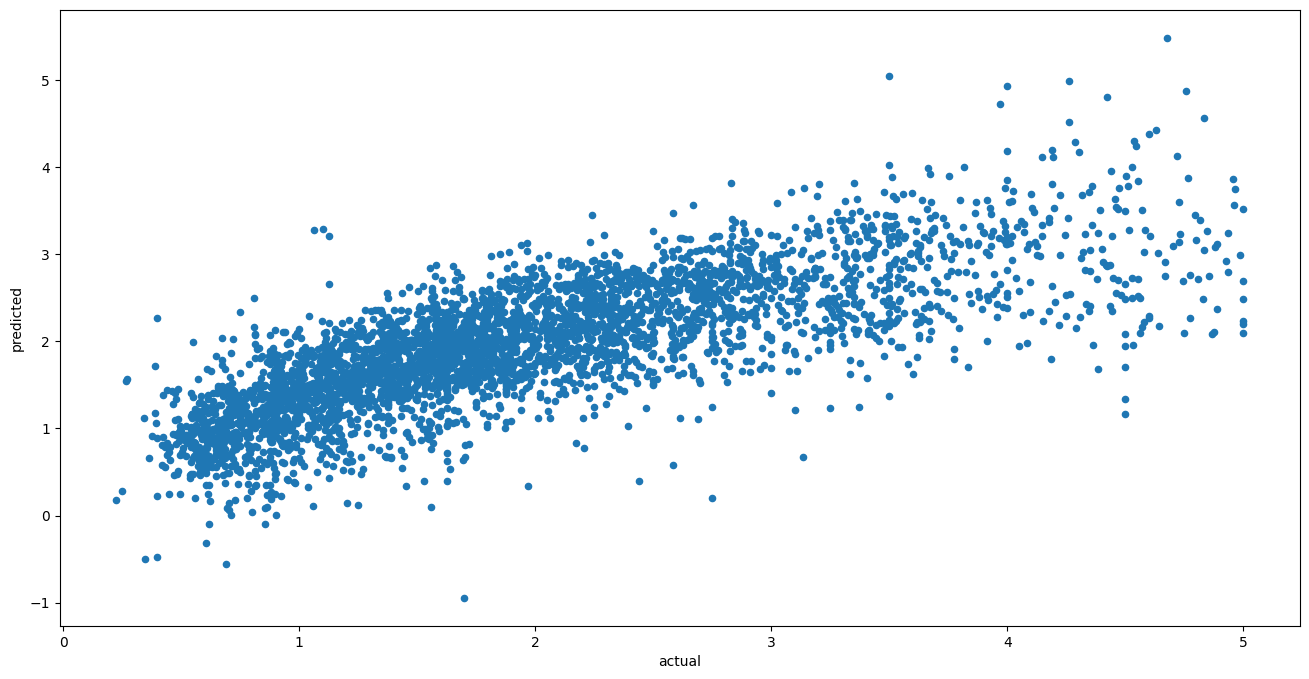

In [39]:
# visualizing prediction vs actuals
dfCompare.plot.scatter(x='actual', y='predicted', figsize=(16,8))

In [42]:
dfCompareSample = dfCompare.sample(100).reset_index(drop=True)
dfCompareSample

,predicted,actual
0,2.013037,1.802
1,1.097915,1.129
2,1.738634,1.641
3,1.918488,0.888
4,2.627136,2.280
...,...,...
95,1.472773,1.308
96,1.594921,1.550
97,2.993765,2.054
98,2.069518,0.813


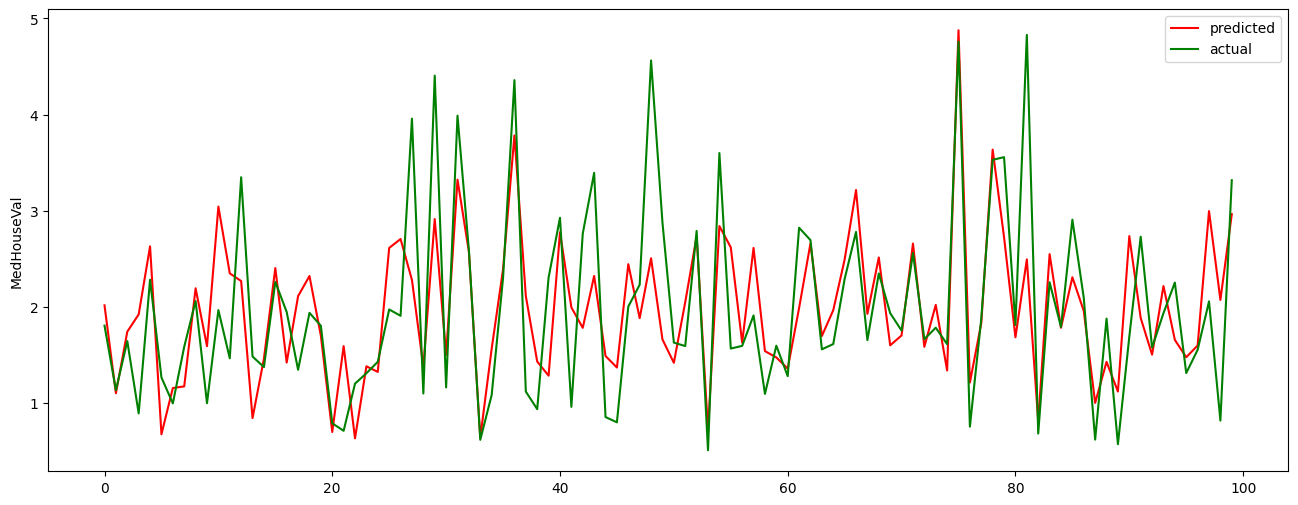

In [53]:
plt.figure(figsize=(16,6))
plt.plot(dfCompareSample.predicted, label='predicted', color='r')
plt.plot(dfCompareSample.actual, label='actual', color='g')
plt.ylabel('MedHouseVal')
plt.legend()
plt.show()